<a href="https://colab.research.google.com/github/astopchatyy/GenAlgoTest/blob/basic_trainer/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from typing import Dict, List, Type, Iterator
from tqdm import tqdm
from abc import ABC, abstractmethod
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
import os
num_workers = os.cpu_count()
num_workers: int = num_workers if num_workers else 1
print("Number of workers:", num_workers)

Device: cuda
Number of workers: 12


In [2]:
import torch
from typing import List
from abc import ABC, abstractmethod

class Metric(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def eval(self, predicted_values: torch.Tensor, true_values: torch.Tensor) -> float:
        return 0.0

    @abstractmethod
    def aggregate(self, values: List) -> float:
        return 0.0



class MSE(Metric):
    def eval(self, predicted_values:torch.Tensor, true_values:torch.Tensor) -> float:
        return torch.mean((predicted_values - true_values) ** 2).item()

    def aggregate(self, values: List) -> float:
        return sum(values)


class Accuracy(Metric):
    def eval(self, predicted_values:torch.Tensor, true_values:torch.Tensor) -> float:
        _, predicted = torch.max(predicted_values, 1)
        return (predicted == true_values).float().mean().item()

    def aggregate(self, values: List) -> float:
        return sum(values) / len(values)

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ShuffleResBlock(BasicBlock):
    def __init__(self, planes, expansion=1):
        super().__init__(planes * expansion, planes, stride=1)
        self.expansion = expansion

class ShuffleResNet(nn.Module):
    def __init__(self, num_blocks: List[int], num_classes=10):
        super(ShuffleResNet, self).__init__()
        self.in_planes = 64
        self.block = BasicBlock
        self.shuffle_block_class = ShuffleResBlock

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(self.block, 128, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(self.block, 256, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(self.block, 512, num_blocks[2], stride=2)

        self.layer4 = self._make_shuffle_layer(ShuffleResBlock, 512, num_blocks[3], stride=1)
        self.layer5 = self._make_shuffle_layer(ShuffleResBlock, 512, num_blocks[4], stride=1)
        self.layer6 = self._make_shuffle_layer(ShuffleResBlock, 512, num_blocks[5], stride=1)


        self.linear = nn.Linear(512 * self.block.expansion, num_classes)

    def _make_layer(self, block: Type[BasicBlock], planes: int, num_blocks: int, stride: int):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride_val in strides:
            layers.append(block(self.in_planes, planes, stride_val))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _make_shuffle_layer(self, block: Type[ShuffleResBlock], planes: int, num_blocks: int, stride: int):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(planes))
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)

        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
class SimpleBlock(nn.Module):
    def __init__(self, in_c, out_c=None, dropout_rate=0.25, pool=True, batch_norm=True):
        super(SimpleBlock, self).__init__()
        if out_c is None:
            out_c = in_c
        self.in_c = in_c
        self.out_c = out_c
        self.conv = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.batch_norm_layer = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.pool = pool
        self.batch_norm = batch_norm
        self.pooling = nn.MaxPool2d(2, 2)


    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.batch_norm:
            x = self.batch_norm_layer(x)
        if self.pool:
            x = self.pooling(x)
        x = self.dropout(x)
        return x

class SimpleCNN(nn.Module):
    def __init__(self, batch_norm=True):
        super(SimpleCNN, self).__init__()
        self.batch_norm = batch_norm
        self.conv1 = SimpleBlock(3, 32, batch_norm=batch_norm)
        self.conv2 = SimpleBlock(32, 64, batch_norm=batch_norm)
        self.conv3 = SimpleBlock(64, 128, batch_norm=batch_norm)
        self.conv4 = SimpleBlock(128, 256, pool=False, batch_norm=batch_norm)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import random
from typing import Dict, List, Type, Any, Union
from tqdm import tqdm
import math

class BasePopulationTrainer:
    def __init__(self,
                 population_size: int,
                 model_class: Type[nn.Module],
                 optimizer_class: Type[optim.Optimizer],
                 criterion: nn.modules.loss._Loss,
                 metric: Metric,
                 scheduler_class: Union[Type[optim.lr_scheduler._LRScheduler], None]=None,
                 model_params: Dict={},
                 optimizer_params: Dict={},
                 scheduler_params: Dict={}) -> None:

        self._model_class = model_class
        self._optimizer_class = optimizer_class
        self._total_population_size = population_size
        self._scheduler_class = scheduler_class
        self._metric = metric
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._model_params = model_params
        self._optimizer_params = optimizer_params
        self._scheduler_params = scheduler_params

        self._population = [self._model_class(**self._model_params).to(self._device)
                            for _ in range(self._total_population_size)]
        self._criterion = criterion
        self._optimizers = [self._optimizer_class(self._population[i].parameters(), **self._optimizer_params)
                            for i in range(self._total_population_size)]
        if not self._scheduler_class is None:
            self._schedulers = [self._scheduler_class(self._optimizers[i], **self._scheduler_params)
                            for i in range(self._total_population_size)]
        else:
            self._schedulers = [None for i in range(self._total_population_size)]
        self._training_history = None

    def _train_one_model_one_epoch(self,
                                   model: nn.Module,
                                   optimizer: optim.Optimizer,
                                   sheduler: Union[optim.lr_scheduler._LRScheduler, None],
                                   criterion: nn.modules.loss._Loss,
                                   dataloader: DataLoader,
                                   pbar: tqdm|None=None,
                                   pbar_message: str|None=None) -> float:
        model.train()
        train_losses = []
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(self._device), labels.to(self._device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            if pbar:
                if pbar_message:
                    pbar.set_description(f"{pbar_message}{i+1}/{len(dataloader)}")
                pbar.update(1)
        if not sheduler is None:
            sheduler.step()
        return sum(train_losses) / len(train_losses)


    def _reset_optimizer(self, optimizer: optim.Optimizer, model: nn.Module, scheduler: Union[optim.lr_scheduler._LRScheduler, None]=None) -> optim.Optimizer:
        new_params = list(model.parameters())
        for group in optimizer.param_groups:
            group["params"] = new_params
        optimizer.state.clear()

        return optimizer

    def _evaluate_model(self, model: nn.Module, dataloader: DataLoader, pbar: tqdm|None=None, pbar_message: str|None=None) -> float:
        model.eval()
        scores = []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloader):
                inputs, labels = inputs.to(self._device), labels.to(self._device)
                outputs = model(inputs)
                scores.append(self._metric.eval(outputs, labels))
                if pbar:
                    if pbar_message:
                        pbar.set_description(f"{pbar_message}{i+1}/{len(dataloader)}")
                    pbar.update(1)
        return self._metric.aggregate(scores)


    def _update_population(self,
                           cycle: int,
                           cycles: int,
                           fitness_scores: List[float],
                           **kwargs: Any) -> List:

        return [None for i in range(self._total_population_size)]


    def train(self,
              cycles: int,
              train_dataloader: DataLoader,
              test_dataloader: DataLoader,
              validation_dataloader: DataLoader|None=None,
              epoches_per_cycle: int = 1,
              verbose: int = 2,
              **kwargs: Any) -> Dict:
        if not validation_dataloader:
            validation_dataloader = train_dataloader

        self._training_history = {
            "update_history": [[] for _ in range(self._total_population_size)],
            "train_losses": [[] for _ in range(self._total_population_size)],
            "test_metric": [[] for _ in range(self._total_population_size)],
            "val_metric": [[] for _ in range(self._total_population_size)],
            "extraction_val_metric": [[] for _ in range(self._total_population_size)],
            "extraction_test_metric": [[] for _ in range(self._total_population_size)]
        }

        if verbose == 2:
            total_len = cycles * self._total_population_size * epoches_per_cycle * (len(train_dataloader) + len(validation_dataloader) + len(test_dataloader))
        elif verbose == 1:
            total_len = cycles * self._total_population_size * epoches_per_cycle
        else:
            total_len = cycles

        with tqdm(total=total_len, leave=False) as pbar:
            for cycle in range(cycles):
                if verbose not in [1, 2]:
                    pbar.set_description(f"Cycle: {cycle+1}/{cycles}")
                    pbar.update(1)

                fitness_scores = []
                for i in range(self._total_population_size):
                    fitness_list = []
                    test_fitness_list = []
                    train_losses_list = []

                    fitness = 0

                    for epoch in range(epoches_per_cycle):
                        message = f"Cycle: {cycle+1}/{cycles}, entity: {i+1}/{self._total_population_size}, epoch: {epoch+1}/{epoches_per_cycle}"

                        if verbose == 2:
                            progr_bar = pbar
                        else:
                            progr_bar = None
                            if verbose == 1:
                                pbar.set_description(message)
                                pbar.update(1)

                        losses = self._train_one_model_one_epoch(self._population[i],
                                                                 self._optimizers[i],
                                                                 self._schedulers[i],
                                                                 self._criterion,
                                                                 train_dataloader,
                                                                 progr_bar,
                                                                 f"{message}, training: ")
                        train_losses_list.append(losses)

                        fitness = self._evaluate_model(self._population[i], validation_dataloader, progr_bar, f"{message}, evaluating validation: ")
                        fitness_list.append(fitness)

                        test_fitness = self._evaluate_model(self._population[i], test_dataloader, progr_bar, f"{message}, evaluating test: ")
                        test_fitness_list.append(test_fitness)

                    self._training_history["train_losses"][i].append(train_losses_list)
                    self._training_history["val_metric"][i].append(fitness_list)
                    self._training_history["test_metric"][i].append(test_fitness_list)

                    fitness_scores.append(fitness)

                extr_model = self.extract_model()
                self._training_history["extraction_val_metric"].append(self._evaluate_model(extr_model, val_loader))
                self._training_history["extraction_test_metric"].append(self._evaluate_model(extr_model, test_loader))

                update_history = self._update_population(cycle, cycles, fitness_scores, **kwargs)

                for i in range(self._total_population_size):
                    self._training_history["update_history"][i].append(update_history[i])

        return self._training_history

    def extract_model(self) -> nn.Module:
        if not self._training_history:
            raise ValueError("Training not performed yet.")

        final_val_metrics = [
            np.mean(model_metrics[-1]) if model_metrics and model_metrics[-1] else 0.0
            for model_metrics in self._training_history["val_metric"]
        ]

        best_model_index = int(np.argmax(final_val_metrics))

        return self._population[best_model_index]

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import random
from typing import Dict, List, Type, Any, Union
from tqdm import tqdm
import math

class GeneticTrainer(BasePopulationTrainer):
    def __init__(self,
                 genetic_population_size: int,
                 superviser_population_size: int,
                 model_class: Type[nn.Module],
                 optimizer_class: Type[optim.Optimizer],
                 criterion: nn.modules.loss._Loss,
                 metric: Metric,
                 scheduler_class: Union[Type[optim.lr_scheduler._LRScheduler], None]=None,
                 model_params: Dict={},
                 optimizer_params: Dict={},
                 scheduler_params: Dict={}) -> None:

        total_population_size = genetic_population_size + superviser_population_size

        super().__init__(
            population_size=total_population_size,
            model_class=model_class,
            optimizer_class=optimizer_class,
            criterion=criterion,
            metric=metric,
            scheduler_class=scheduler_class,
            model_params=model_params,
            optimizer_params=optimizer_params,
            scheduler_params=scheduler_params
        )

        self._genetic_population_size = genetic_population_size
        self._superviser_population_size = superviser_population_size

    def _update_population(self,
                            cycle: int,
                            cycles: int,
                            fitness_scores: List[float],
                            survivor_fraction: float = 0.5,
                            mutation_chance: float = 0.1,
                            last_cycle_evolution=True,
                            **kwargs: Any) -> List:

        history: List[Any] = [None for i in range(self._total_population_size)]

        if cycle < cycles - 1 or last_cycle_evolution:
            ranked = sorted(list(zip(fitness_scores[:self._genetic_population_size], list(range(self._genetic_population_size)))), key=lambda x: x[0], reverse=True)

            survivors_count = math.ceil(self._genetic_population_size * survivor_fraction)

            for _, index in ranked[survivors_count:]:
                index_a, index_b = random.sample(range(survivors_count), 2)
                history[index] = (cycle, index_a, index_b)

                self._population[index] = self._crossover(self._population[index_a], self._population[index_b], mutation_chance)
                self._optimizers[index] = self._reset_optimizer(self._optimizers[index], self._population[index], self._schedulers[index])


        return history


    def _crossover(self, model_a: nn.Module, model_b: nn.Module, mutation_chance: float) -> nn.Module:
        child = self._model_class(**self._model_params).to(self._device)
        with torch.no_grad():
            mods_a = dict(model_a.named_modules())
            mods_b = dict(model_b.named_modules())
            if self._superviser_population_size and mutation_chance:
                mutation_index = random.sample(range(self._superviser_population_size), 1)[0]
                mods_mut = dict(self._population[mutation_index].named_modules())

            for name, module_child in child.named_modules():

                if len(list(module_child.children())) != 0:
                    continue

                if self._superviser_population_size and  mutation_chance and random.random() < mutation_chance:
                    src = mods_mut[name] # type: ignore
                elif random.random() < 0.5:
                    src = mods_a[name]
                else:
                    src = mods_b[name]

                for param_child, param_src in zip(module_child.parameters(), src.parameters()):
                    param_child.data.copy_(param_src.data)

                for buf_name, buf_child in module_child.named_buffers():
                    buf_src = getattr(src, buf_name)
                    buf_child.copy_(buf_src)
        return child

    def _layerwise_mse(self, model_a: nn.Module, model_b: nn.Module):
        layers_a = [m for m in model_a.modules() if len(list(m.parameters())) > 0]
        layers_b = [m for m in model_b.modules() if len(list(m.parameters())) > 0]

        mses = []
        for la, lb in zip(layers_a, layers_b):
            params_a = torch.cat([p.view(-1) for p in la.parameters()])
            params_b = torch.cat([p.view(-1) for p in lb.parameters()])
            mse = nn.functional.mse_loss(params_a, params_b).item()
            mses.append(mse)

        return torch.mean(torch.Tensor(mses)).item()

    def extract_model(self, smilarity_fraction: float=0.8) -> nn.Module:
        mses = [[] for i in range(self._genetic_population_size)]
        for i in range(self._genetic_population_size):
          for j in range(i + 1, self._genetic_population_size):
            mses[i].append(self._layerwise_mse(self._population[i], self._population[j]))
            mses[j].append(self._layerwise_mse(self._population[i], self._population[j]))

        row_means = np.mean(mses, axis=1)
        selector = row_means <= np.quantile(row_means, smilarity_fraction)

        avg_model = self._model_class(**self._model_params).to(self._device)
        avg_state = avg_model.state_dict()

        keys = avg_state.keys()
        for key in keys:
            stacked = torch.stack([self._population[i].state_dict()[key] for i in range(self._genetic_population_size) if selector[i]], dim=0)
            if stacked.dtype != torch.float32:
                avg_state[key] = stacked[0]
            else:
                avg_state[key] = stacked.mean(dim=0)

        avg_model.load_state_dict(avg_state)
        return avg_model


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

base_train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170M/170M [00:04<00:00, 42.2MB/s]


In [8]:
validation_fraction = 0.2
validation_size = int(len(testset) * validation_fraction)
seed = 42
g = torch.Generator().manual_seed(seed)
valset, trainset = torch.utils.data.random_split(base_train_set, [validation_size, len(base_train_set) - validation_size], generator=g)

val_loader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=num_workers)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=False, num_workers=num_workers)

In [ ]:
# pop_size = 1
# trainer = ShuffleTrainer(pop_size, ShuffleResNet, optim.Adam, nn.CrossEntropyLoss(), Accuracy(), [ShuffleResBlock], optimizer_params={"lr": 0.005}, model_params={"num_blocks": [1,1,1,1,1,1]})
# history = []

In [48]:
pop_size = 4
trainer = GeneticTrainer(pop_size, 0, SimpleCNN, optim.Adam, nn.CrossEntropyLoss(), Accuracy(), scheduler_class=optim.lr_scheduler.CosineAnnealingLR, optimizer_params={"lr": 0.001}, scheduler_params={"T_max": 200})
history = []

In [49]:
history.append(trainer.train(1, train_loader, test_loader, val_loader, epoches_per_cycle=1, verbose=1))

[(0.63916015625, 2), (0.6346679702401161, 0), (0.6346679702401161, 1), (0.6291015632450581, 3)]
1
3


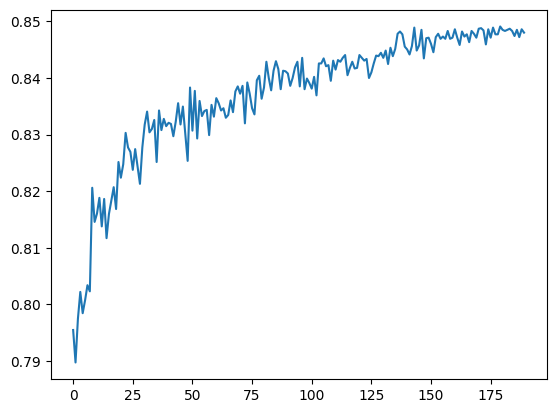

In [ ]:
plt.plot(history[0]["test_metric"][0][0][10:])

In [80]:
pop_size2 = 8
cycles = 20
#trainer2 = GeneticTrainer(pop_size2, 0, SimpleCNN, optim.AdamW, nn.CrossEntropyLoss(), Accuracy(), scheduler_class=optim.lr_scheduler.CosineAnnealingWarmRestarts, model_params={"batch_norm": False}, optimizer_params={"lr": 0.001}, scheduler_params={"T_0": cycles, "eta_min": 0.00005})
trainer2 = GeneticTrainer(pop_size2, 0, SimpleCNN, optim.Adam, nn.CrossEntropyLoss(), Accuracy(), model_params={"batch_norm": False}, optimizer_params={"lr": 0.001})
history2 = []
h3 = []

In [90]:
c2 = 20
for i in tqdm(range(c2)):
  history2.append(trainer2.train(1, train_loader, test_loader, val_loader, epoches_per_cycle=1, last_cycle_evolution=(i < c2 - 1), verbose=0))
  h3.append(trainer2._evaluate_model(trainer2.extract_model(), test_loader))

100%|██████████| 20/20 [11:18<00:00, 33.90s/it]


In [91]:
h3

[0.10027689873417721,
 0.16366693037974683,
 0.43710443037974683,
 0.5233386075949367,
 0.5194818037974683,
 0.5953322784810127,
 0.7412974683544303,
 0.7497033227848101,
 0.7643393987341772,
 0.7672072784810127,
 0.7774920886075949,
 0.7820411392405063,
 0.7785799050632911,
 0.7869857594936709,
 0.7917325949367089,
 0.7925237341772152,
 0.7964794303797469,
 0.8010284810126582,
 0.7982594936708861,
 0.8032041139240507,
 0.8009295886075949,
 0.8041930379746836,
 0.8047863924050633,
 0.8010284810126582,
 0.8069620253164557,
 0.8120055379746836,
 0.8106210443037974,
 0.8096321202531646,
 0.8103243670886076,
 0.8064675632911392,
 0.8125988924050633,
 0.8105221518987342,
 0.8122033227848101,
 0.8127966772151899,
 0.817939082278481,
 0.811807753164557,
 0.8169501582278481,
 0.8176424050632911,
 0.8134889240506329,
 0.8178401898734177,
 0.8127966772151899,
 0.8120055379746836,
 0.8170490506329114,
 0.8158623417721519,
 0.8173457278481012,
 0.814181170886076,
 0.8180379746835443,
 0.8176424050

In [92]:
h4 = []
for el in history2:
  h4.append(max([el["test_metric"][i][0][0] for i in range(8)]))
h4

[0.5166139240506329,
 0.5926621835443038,
 0.6535799050632911,
 0.694620253164557,
 0.7168710443037974,
 0.7267602848101266,
 0.7423852848101266,
 0.7532634493670886,
 0.7607792721518988,
 0.7677017405063291,
 0.7693829113924051,
 0.7701740506329114,
 0.7722507911392406,
 0.7787776898734177,
 0.7884691455696202,
 0.7847112341772152,
 0.7909414556962026,
 0.7920292721518988,
 0.7933148734177216,
 0.7969738924050633,
 0.7946993670886076,
 0.7980617088607594,
 0.8035007911392406,
 0.8005340189873418,
 0.8036985759493671,
 0.8020174050632911,
 0.803006329113924,
 0.8068631329113924,
 0.8048852848101266,
 0.8096321202531646,
 0.807060917721519,
 0.8054786392405063,
 0.8095332278481012,
 0.8085443037974683,
 0.8081487341772152,
 0.8107199367088608,
 0.810126582278481,
 0.8137856012658228,
 0.8115110759493671,
 0.8071598101265823,
 0.8116099683544303,
 0.810126582278481,
 0.8119066455696202,
 0.8087420886075949,
 0.811807753164557,
 0.811807753164557,
 0.8125,
 0.8122033227848101,
 0.81428006

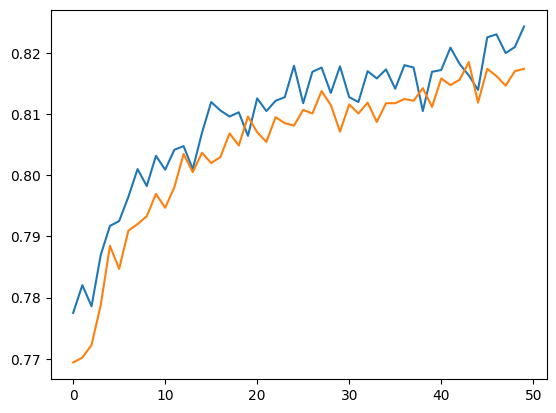

In [93]:
plt.plot(h3[10:])
plt.plot(h4[10:])
plt.show()

In [ ]:
max_vals = [0 for _ in range(pop_size)]
test_vals = [0 for _ in range(pop_size)]
for i in range(pop_size):
    for el in history[-1]["val_metric"][i]:
        for val in el:
            if val > max_vals[i]:
                max_vals[i] = val
                test_vals[i] = history[-1]["test_metric"][i][-1][-1]

print(max_vals)
print(max(max_vals))

print("====")
print(test_vals)
print(test_vals[np.argmax(max_vals)])

[0.8293945305049419]
0.8293945305049419
====
[0.8081487341772152]
0.8081487341772152


In [ ]:
model = trainer.extract_model(0.8)
trainer._evaluate_model(model, test_loader)

0.821993670886076

In [ ]:
for i in range(trainer._genetic_population_size):
  torch.save(trainer._population[i], f"/content/drive/MyDrive/gen_algo/4l/gen/model_4l_gen_{i}")

In [ ]:
for i in range(trainer._genetic_population_size):
  trainer._population[i] = torch.load(f"/content/drive/MyDrive/gen_algo/4l/gen/model_4l_gen_{i}", weights_only=False)

for i in range(trainer._superviser_population_size):
  trainer._population[trainer._genetic_population_size + i] = torch.load(f"/content/drive/MyDrive/gen_algo/4l/sep/model_4l_sep_{i}", weights_only=False)

In [ ]:
pops = []
for i in range(trainer._genetic_population_size):
  model = trainer._population[i]
  pops.append(model)

In [ ]:
for i in range(trainer._genetic_population_size):
  index_a, index_b = random.sample(range(len(pops)), 2)
  trainer._population[i] = trainer._crossover(pops[index_a], pops[index_b], mutation_chance=0.3)

In [ ]:
h = [[],[]]
h[0] = trainer.train(4, train_loader, test_loader, val_loader, epoches_per_cycle=1, last_cycle_evolution=False, mutation_chance=0.4)
h[1] = trainer.train(4, train_loader, test_loader, val_loader, epoches_per_cycle=1, last_cycle_evolution=False, mutation_chance=0)

In [ ]:
model = trainer.extract_model(1)
trainer._evaluate_model(model, test_loader)

0.8269382911392406

In [ ]:
model = trainer.extract_model(1)
trainer._evaluate_model(model, test_loader)

0.8267405063291139

In [ ]:
trainer2 = GeneticTrainer(1, 0, SimpleCNN, optim.Adam, nn.CrossEntropyLoss(), Accuracy(), optimizer_params={"lr": 0.001})
hh = trainer2.train(1, train_loader, test_loader, val_loader, epoches_per_cycle=200, last_cycle_evolution=False, mutation_chance=0)


In [ ]:
print(max(hh["val_metric"][0][0]), np.argmax(hh["val_metric"][0][0]), hh["test_metric"][0][0][np.argmax(hh["val_metric"][0][0])])

0.8433593772351742 195 0.8214003164556962


In [ ]:
[h[1]["test_metric"][i][-1] for i in range(len(h[1]["test_metric"]))]

[[0.8163568037974683],
 [0.8149723101265823],
 [0.8134889240506329],
 [0.811807753164557],
 [0.8158623417721519],
 [0.8145767405063291],
 [0.8084454113924051],
 [0.8166534810126582],
 [0.8089398734177216],
 [0.8143789556962026],
 [0.8137856012658228],
 [0.8194224683544303],
 [0.8082476265822784],
 [0.8157634493670886],
 [0.807060917721519],
 [0.806368670886076]]

In [ ]:
for i in range(trainer2._genetic_population_size):
  torch.save(trainer2._population[i], f"/content/drive/MyDrive/gen_algo/4l/sep/model_4l_sep_{i}")

In [ ]:
for i in range(trainer2._genetic_population_size):
  trainer2._population[i] = torch.load(f"/content/drive/MyDrive/gen_algo/4l/sep/model_4l_sep_{i}", weights_only=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.makedirs("/content/drive/MyDrive/gen_algo/4l/gen", exist_ok=True)
os.makedirs("/content/drive/MyDrive/gen_algo/4l/sep", exist_ok=True)

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import random
from typing import Dict, List, Type
from tqdm import tqdm
import math

class GeneticTrainer:
    def __init__(self,
                 genetic_population_size: int,
                 superviser_population_size: int,
                 model_class: Type[nn.Module],
                 optimizer_class: Type[optim.Optimizer],
                 criterion: nn.modules.loss._Loss,
                 metric: Metric,
                 model_params: Dict={},
                 optimizer_params: Dict={}) -> None:

        self._model_class = model_class
        self._optimizer_class = optimizer_class
        self._genetic_population_size = genetic_population_size
        self._superviser_population_size = superviser_population_size
        self._total_population_size = self._superviser_population_size + self._genetic_population_size
        self._metric = metric
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._model_params = model_params
        self._optimizer_params = optimizer_params

        self._population = [self._model_class(**self._model_params).to(self._device) for _ in range(self._total_population_size)]
        self._criterion = criterion
        self._optimizers = [self._optimizer_class(self._population[i].parameters(), **self._optimizer_params) for i in range(self._total_population_size)]

        self._training_history = None


    def train(self,
              cycles: int,
              train_dataloader: DataLoader,
              test_dataloader: DataLoader,
              validation_dataloader: DataLoader|None=None,
              survivor_fraction: float = 0.5,
              mutation_chance: float = 0.1,
              epoches_per_cycle=1,
              last_cycle_evolution=True,
              verbose=2) -> Dict:


        if not validation_dataloader:
            validation_dataloader = train_dataloader


        self._training_history = {
            "crossover_history": [[] for _ in range(self._genetic_population_size + self._superviser_population_size)],
            "train_losses": [[] for _ in range(self._genetic_population_size + self._superviser_population_size)],
            "test_metric": [[] for _ in range(self._genetic_population_size + self._superviser_population_size)],
            "val_metric": [[] for _ in range(self._genetic_population_size + self._superviser_population_size)]

        }

        if verbose == 2:
            total_len = cycles * (self._total_population_size) * epoches_per_cycle * (len(train_dataloader) + len(validation_dataloader) + len(test_dataloader))
        elif verbose == 1:
            total_len = cycles * (self._total_population_size) * epoches_per_cycle

        else:
            total_len = cycles

        with tqdm(total=total_len, leave=False) as pbar:
            for cycle in range(cycles):
                if verbose not in [1,2]:
                    pbar.set_description(f"Cycle: {cycle+1}/{cycles}")
                    pbar.update(1)
                fitness_scores = []
                for i in range(self._total_population_size):
                    fitness_list = []
                    test_fitness_list = []
                    train_losses_list = []

                    fitness = 0

                    for epoch in range(epoches_per_cycle):
                        message = f"Cycle: {cycle+1}/{cycles}, entity: {i+1}/{self._total_population_size}, epoch:{epoch+1}/{epoches_per_cycle}"
                        if verbose == 2:
                            progr_bar = pbar
                        else:
                            progr_bar = None
                            if verbose == 1:
                                pbar.set_description(message)
                                pbar.update(1)
                        losses = self._train_one_model_one_epoch(self._population[i],
                                                                self._optimizers[i],
                                                                self._criterion,
                                                                train_dataloader,
                                                                progr_bar,
                                                                f"{message}, training: ")
                        train_losses_list.append(losses)
                        fitness = self._evaluate_model(self._population[i], validation_dataloader, progr_bar, f"{message}, evaluating validation: ")
                        fitness_list.append(fitness)
                        test_fitness = self._evaluate_model(self._population[i], test_dataloader, progr_bar, f"{message}, evaluating test: ")
                        test_fitness_list.append(test_fitness)

                    fitness_scores.append(fitness)
                    self._training_history["train_losses"][i].append(train_losses_list)
                    self._training_history["val_metric"][i].append(fitness_list)
                    self._training_history["test_metric"][i].append(test_fitness_list)

                if cycle < cycles - 1 or last_cycle_evolution:
                  ranked = sorted(list(zip(fitness_scores[:self._genetic_population_size], list(range(self._genetic_population_size)))), key=lambda x: x[0], reverse=True)
                  survivors_count = math.ceil(self._genetic_population_size * survivor_fraction)

                  for _, index in ranked[survivors_count:]:
                      index_a, index_b = random.sample(range(survivors_count), 2)
                      self._training_history["crossover_history"][index].append((cycle, index_a, index_b))

                      self._population[index] = self._crossover(self._population[index_a], self._population[index_b], mutation_chance)
                      self._optimizers[index] = self._reset_optimizer(self._optimizers[index], self._population[index])


        return self._training_history

    def _crossover(self, model_a: nn.Module, model_b: nn.Module, mutation_chance: float) -> nn.Module:
        child = self._model_class(**self._model_params).to(self._device)
        with torch.no_grad():
            mods_a = dict(model_a.named_modules())
            mods_b = dict(model_b.named_modules())
            if self._superviser_population_size and mutation_chance:
                mutation_index = random.sample(range(self._superviser_population_size), 1)[0]
                mods_mut = dict(self._population[mutation_index].named_modules())

            for name, module_child in child.named_modules():
                if len(list(module_child.children())) != 0:
                    continue

                if self._superviser_population_size and  mutation_chance and random.random() < mutation_chance:
                    src = mods_mut[name] # type: ignore
                elif random.random() < 0.5:
                    src = mods_a[name]
                else:
                    src = mods_b[name]

                for param_child, param_src in zip(module_child.parameters(), src.parameters()):
                    param_child.data.copy_(param_src.data)

                for buf_name, buf_child in module_child.named_buffers():
                    buf_src = getattr(src, buf_name)
                    buf_child.copy_(buf_src)
        return child

    def _train_one_model_one_epoch(self,
                                   model: nn.Module,
                                   optimizer: optim.Optimizer,
                                   criterion: nn.modules.loss._Loss,
                                   dataloader: DataLoader,
                                   pbar: tqdm|None=None,
                                   pbar_message: str|None=None) -> List:

        model.train()
        train_losses = []
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(self._device), labels.to(self._device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            if pbar:
                if pbar_message:
                    pbar.set_description(f"{pbar_message}{i+1}/{len(dataloader)}")
                pbar.update(1)

        return train_losses

    def _evaluate_model(self, model: nn.Module, dataloader: DataLoader,  pbar: tqdm|None=None, pbar_message: str|None=None) -> float:
        model.eval()
        scores = []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloader):
                inputs, labels = inputs.to(self._device), labels.to(self._device)
                outputs = model(inputs)
                scores.append(self._metric.eval(outputs, labels))
                if pbar:
                    if pbar_message:
                        pbar.set_description(f"{pbar_message}{i+1}/{len(dataloader)}")
                    pbar.update(1)
        return self._metric.aggregate(scores)

    def _reset_optimizer(self, optimizer: optim.Optimizer, model: nn.Module) -> optim.Optimizer:
        param_groups = optimizer.param_groups

        base_hyperparams = {k: v for k, v in param_groups[0].items() if k != 'params'}

        return self._optimizer_class(model.parameters(), **base_hyperparams)

    def _layerwise_mse(self, model_a: nn.Module, model_b: nn.Module):
        layers_a = [m for m in model_a.modules() if len(list(m.parameters())) > 0]
        layers_b = [m for m in model_b.modules() if len(list(m.parameters())) > 0]
        mses = []
        for la, lb in zip(layers_a, layers_b):
            params_a = torch.cat([p.view(-1) for p in la.parameters()])
            params_b = torch.cat([p.view(-1) for p in lb.parameters()])
            mse = nn.functional.mse_loss(params_a, params_b).item()
            mses.append(mse)

        return torch.mean(torch.Tensor(mses)).item()

    def extract_model(self, smilarity_fraction: float=0.8) -> nn.Module:
        mses = [[] for i in range(self._genetic_population_size)]
        for i in range(self._genetic_population_size):
          for j in range(i + 1, self._genetic_population_size):
            mses[i].append(self._layerwise_mse(self._population[i], self._population[j]))
            mses[j].append(self._layerwise_mse(self._population[i], self._population[j]))

        row_means = np.mean(mses, axis=1)
        selector = row_means <= np.quantile(row_means, smilarity_fraction)

        avg_model = self._model_class(**self._model_params).to(self._device)
        avg_state = avg_model.state_dict()

        keys = avg_state.keys()
        for key in keys:
            stacked = torch.stack([self._population[i].state_dict()[key] for i in range(self._genetic_population_size) if selector[i]], dim=0)
            if
            avg_state[key] = stacked.mean(dim=0)

        avg_model.load_state_dict(avg_state)
        return avg_model

In [64]:
trainer = GeneticTrainer(8, 0, SimpleCNN, optim.Adam, nn.CrossEntropyLoss(), Accuracy(), model_params={"batch_norm": False}, optimizer_params={"lr": 0.001})

In [71]:
h = trainer.train(24, train_loader, test_loader, val_loader, last_cycle_evolution=False, verbose=1)

In [73]:
model = extract_model(trainer)
trainer._evaluate_model(model, test_loader)

0.8166534810126582

In [69]:
def extract_model(self, smilarity_fraction: float=0.8) -> nn.Module:
    mses = [[] for i in range(self._genetic_population_size)]
    for i in range(self._genetic_population_size):
      for j in range(i + 1, self._genetic_population_size):
        mses[i].append(self._layerwise_mse(self._population[i], self._population[j]))
        mses[j].append(self._layerwise_mse(self._population[i], self._population[j]))

    row_means = np.mean(mses, axis=1)
    selector = row_means <= np.quantile(row_means, smilarity_fraction)

    avg_model = self._model_class(**self._model_params).to(self._device)
    avg_state = avg_model.state_dict()

    keys = avg_state.keys()
    for key in keys:
        stacked = torch.stack([self._population[i].state_dict()[key] for i in range(self._genetic_population_size) if selector[i]], dim=0)
        if stacked.dtype == torch.float32:
            avg_state[key] = stacked.mean(dim=0)
        else:
            avg_state[key] = stacked[0]

    avg_model.load_state_dict(avg_state)
    return avg_model